In [48]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import re
import pickle
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [49]:
# Load data
df = pd.read_csv('News_SocialMedia.csv')
df = df[['Title', 'Headline', 'Topic']]
df.head(3)

,Title,Headline,Topic
0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,obama
1,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",economy
2,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",economy


In [50]:
# Removing stop words and lemmatizing text
df = df.drop(df[df['Title'].isna()].index, axis=0)
df = df.drop(df[df['Headline'].isna()].index, axis=0)

lemmatizer = WordNetLemmatizer()
clean = []
for t in df['Headline']:
    words = regexp_tokenize(t.lower(), r'[A-Za-z]+')
    words = [w for w in words if len(w)>1 and w not in stopwords.words('english')]
    words = [lemmatizer.lemmatize(w) for w in words]
    clean.append(' '.join(words))
df['CleanHeadline'] = clean  

In [51]:
df.to_pickle('News_SocialMedia_Df.pkl')

In [52]:
df = pd.read_pickle("News_SocialMedia_Df.pkl")

In [53]:
df = df.sample(5000)

In [54]:
HeadlineTokens = []
for sen in df['CleanHeadline']:
    tokens = sen.split()
    HeadlineTokens.append(tokens)
df['HeadlineTokens'] = HeadlineTokens

all_headlines = ' '.join(df['CleanHeadline'])
all_words = all_headlines.split()                   
tokens = set(all_words)
len(tokens) 

11456

### Clustering using TF-IDF input

In [13]:
# Preparing TF-IDF input
headlines_list = df['CleanHeadline'].tolist() 
tfidf_vectorizer = TfidfVectorizer(max_features=50000, min_df=0.15, ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(headlines_list)
similarity_matrix = (tfidf_matrix * tfidf_matrix.T).A

###### K-Means Clustering

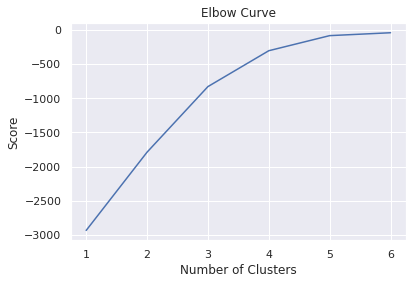

In [55]:
# Plot Elbow Curve to find optimum "K" value
N = range(1, 7)
kmeans_test = [KMeans(n_clusters=i) for i in N]
score = [kmeans_test[i].fit(tfidf_matrix).score(tfidf_matrix) for i in range(len(kmeans_test))]
plt.plot(N, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [56]:
num_clusters = 5
km_tfidf = KMeans(n_clusters=num_clusters)
km_tfidf.fit(tfidf_matrix)
km_tfidf_labels = km_tfidf.labels_
km_tfidf_clusters = km_tfidf_labels.tolist()
df['kmeans_tfidf'] = km_tfidf_clusters

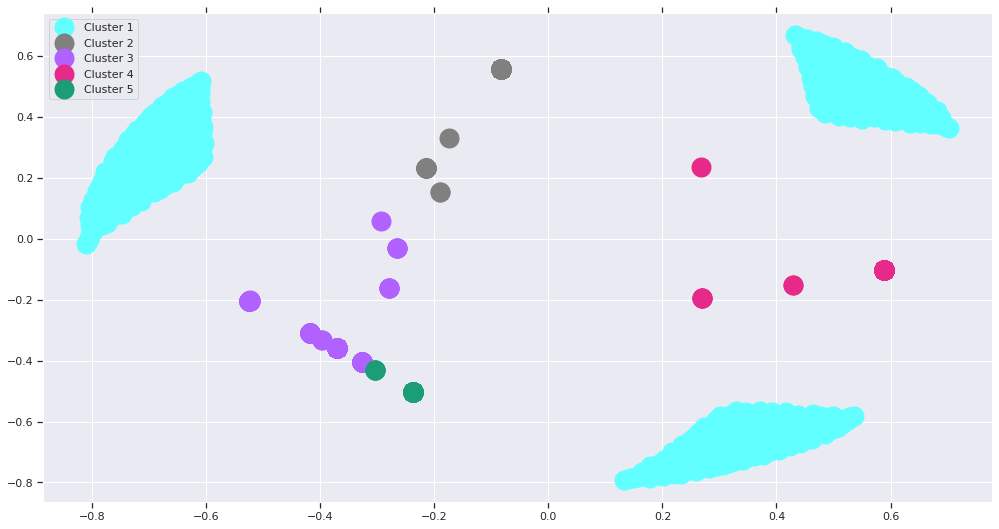

In [57]:
# Plot clusters of a subset - 2000 records 
from sklearn.metrics.pairwise import cosine_similarity
distance = 1 - cosine_similarity(tfidf_matrix[0:2000]) 

from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
pos = mds.fit_transform(distance)
xs, ys = pos[:, 0], pos[:, 1]

# Set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4',4:'Cluster 5'}
cluster_colors = {0: '#61ffff', 1: '#808080', 2: '#B061FF', 3: '#e7298a',4: '#1b9e77'}

# Plot clusters
df_plot = pd.DataFrame(dict(x=xs, y=ys, label=km_tfidf_clusters[0:2000])) 
groups = df_plot.groupby('label')
fig, ax = plt.subplots(figsize=(17, 9))

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, 
            label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
ax.legend(numpoints=1) 
plt.show()

#### Agglomerative Clustering

In [58]:
agglomerativeclustering = AgglomerativeClustering(n_clusters=num_clusters)
ac_tfidf_clusters = agglomerativeclustering.fit(similarity_matrix)
ac_tfidf_labels = ac_tfidf_clusters.labels_
ac_tfidf_clusters = ac_tfidf_labels.tolist()
df['agglo_tfidf'] = ac_tfidf_clusters

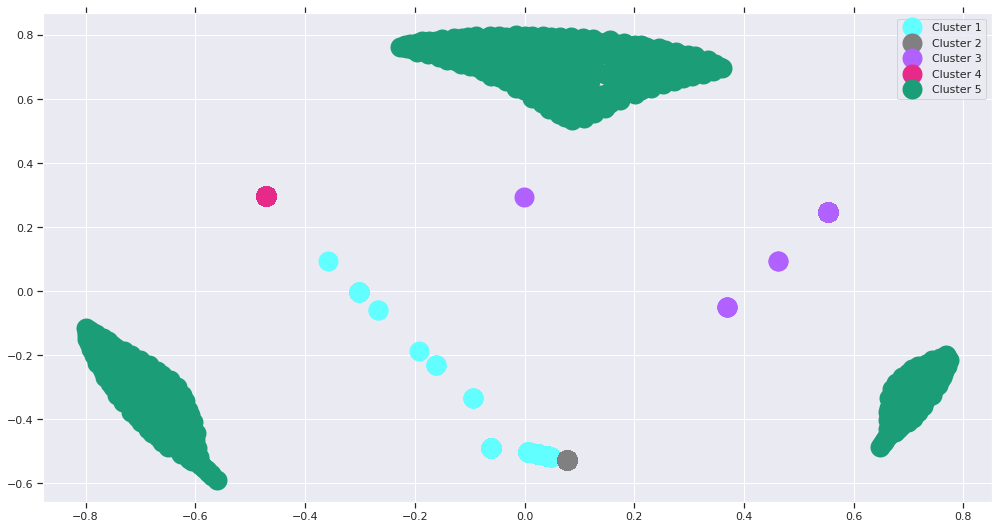

In [59]:
# Plot clusters of a subset - 2000 records 
from sklearn.metrics.pairwise import cosine_similarity
distance = 1 - cosine_similarity(similarity_matrix[0:2000]) 

from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
pos = mds.fit_transform(distance)
xs, ys = pos[:, 0], pos[:, 1]

# Set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4',4:'Cluster 5'}
cluster_colors = {0: '#61ffff', 1: '#808080', 2: '#B061FF', 3: '#e7298a',4: '#1b9e77'}

# Plot clusters
df_plot = pd.DataFrame(dict(x=xs, y=ys, label=ac_tfidf_clusters[0:2000])) 
groups = df_plot.groupby('label')
fig, ax = plt.subplots(figsize=(17, 9))

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, 
            label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
ax.legend(numpoints=1) 
plt.show()

### Clustering using Word Vectors as input

In [60]:
from gensim.utils import simple_preprocess
tokenized_list = [simple_preprocess(h) for h in df['Headline']]
from sklearn.model_selection import train_test_split
import numpy as np
train_corpus = np.array(tokenized_list)

from gensim.models import Word2Vec
num_features = 100
model = Word2Vec(train_corpus, size=num_features, window=8, min_count=2, sample=1e-3, sg=1, iter=5, workers=8)
vocab = set(model.wv.index2word)

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

train_features = [average_word_vectors(sent_tokens, model, vocab, num_features) for sent_tokens in train_corpus]
avg_train_features = np.array(train_features)

#### K-Means Clustering

In [61]:
km_wordvec = KMeans(n_clusters=num_clusters)
km_wordvec.fit(avg_train_features)
km_wordvec_labels = km_wordvec.labels_
km_wordvec_clusters = km_wordvec_labels.tolist()
df['kmeans_wordvec'] = km_wordvec_clusters

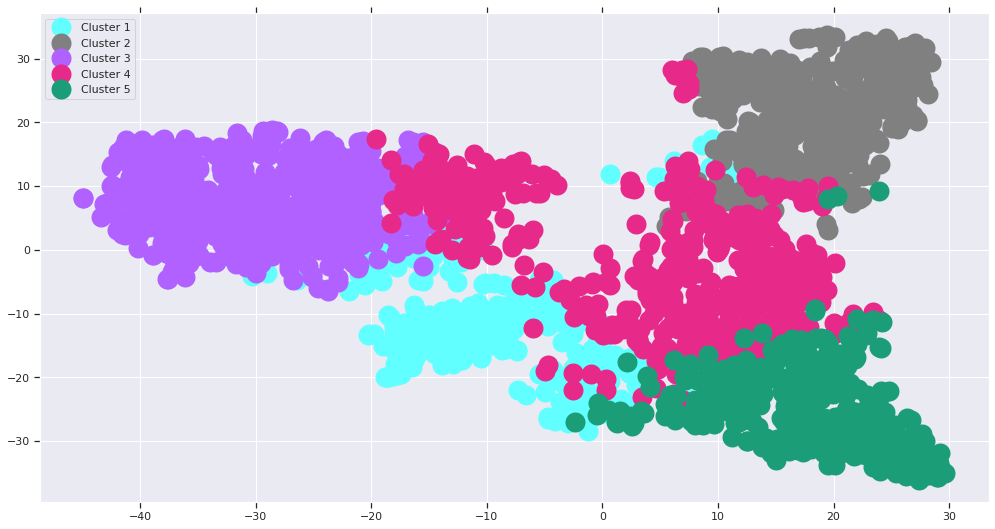

In [62]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='random', random_state=42, perplexity=50)
pos = tsne.fit_transform(avg_train_features[:2000]) 
xs, ys = pos[:, 0], pos[:, 1]

# Set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4',4:'Cluster 5'}
cluster_colors = {0: '#61ffff', 1: '#808080', 2: '#B061FF', 3: '#e7298a',4: '#1b9e77'}

# Plot clusters
df_plot = pd.DataFrame(dict(x=xs, y=ys, label=km_wordvec_clusters[0:2000])) 
groups = df_plot.groupby('label')
fig, ax = plt.subplots(figsize=(17, 9))

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, 
            label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
ax.legend(numpoints=1) 
plt.show()

#### Agglomerative Clustering

In [63]:
agglomerativeclustering = AgglomerativeClustering(n_clusters=num_clusters)
ac_wordvec_clusters = agglomerativeclustering.fit(avg_train_features)
ac_wordvec_labels = ac_wordvec_clusters.labels_
ac_wordvec_clusters = ac_wordvec_labels.tolist()
df['agglo_wordvec'] = ac_wordvec_clusters

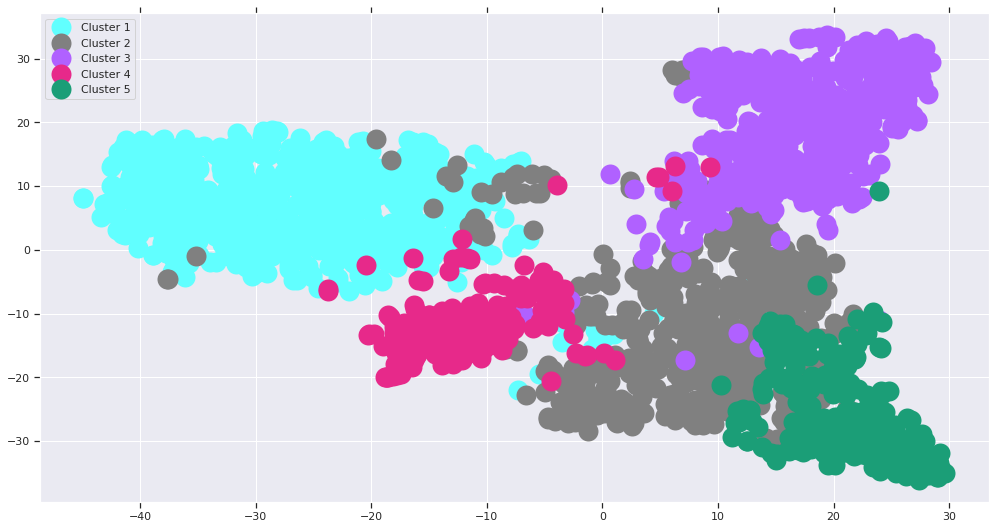

In [64]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='random', random_state=42, perplexity=50)
pos = tsne.fit_transform(avg_train_features[:2000]) 
xs, ys = pos[:, 0], pos[:, 1]

# Set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4',4:'Cluster 5'}
cluster_colors = {0: '#61ffff', 1: '#808080', 2: '#B061FF', 3: '#e7298a',4: '#1b9e77'}

# Plot clusters
df_plot = pd.DataFrame(dict(x=xs, y=ys, label=ac_wordvec_clusters[0:2000])) 
groups = df_plot.groupby('label')
fig, ax = plt.subplots(figsize=(17, 9))

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, 
            label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
ax.legend(numpoints=1) 
plt.show()

### Clustering using Doc2Vec Input

In [65]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokenized_list)]
d2v_model = Doc2Vec(documents, size=num_features, window=8, min_count=2, workers=7)
d2v_model.train(documents, total_examples=d2v_model.corpus_count, epochs=10)

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


#### K-Means Clustering

In [66]:
km_docvec = KMeans(n_clusters=num_clusters)
km_docvec.fit(d2v_model.docvecs.vectors_docs)
km_docvec_labels = km_docvec.labels_
km_docvec_clusters = km_docvec_labels.tolist()
df['kmeans_docvec'] = km_docvec_clusters

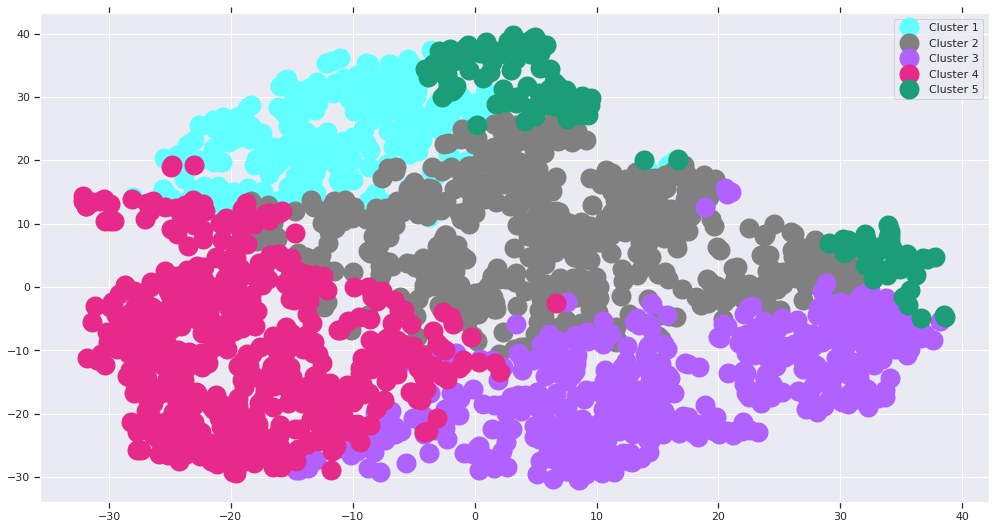

In [67]:
tsne = TSNE(n_components=2, init='random', random_state=42, perplexity=50)
pos = tsne.fit_transform(d2v_model.docvecs.vectors_docs[:2000]) 
xs, ys = pos[:, 0], pos[:, 1]

# Set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4',4:'Cluster 5'}
cluster_colors = {0: '#61ffff', 1: '#808080', 2: '#B061FF', 3: '#e7298a',4: '#1b9e77'}

# Plot clusters
df_plot = pd.DataFrame(dict(x=xs, y=ys, label=km_docvec_clusters[0:2000])) 
groups = df_plot.groupby('label')
fig, ax = plt.subplots(figsize=(17, 9))

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, 
            label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
ax.legend(numpoints=1) 
plt.show()

#### Agglomerative Clustering

In [68]:
agglomerativeclustering = AgglomerativeClustering(n_clusters=num_clusters)
ac_docvec_clusters = agglomerativeclustering.fit(d2v_model.docvecs.vectors_docs)
ac_docvec_labels = ac_docvec_clusters.labels_
ac_docvec_clusters = ac_docvec_labels.tolist()
df['agglo_docvec'] = ac_docvec_clusters

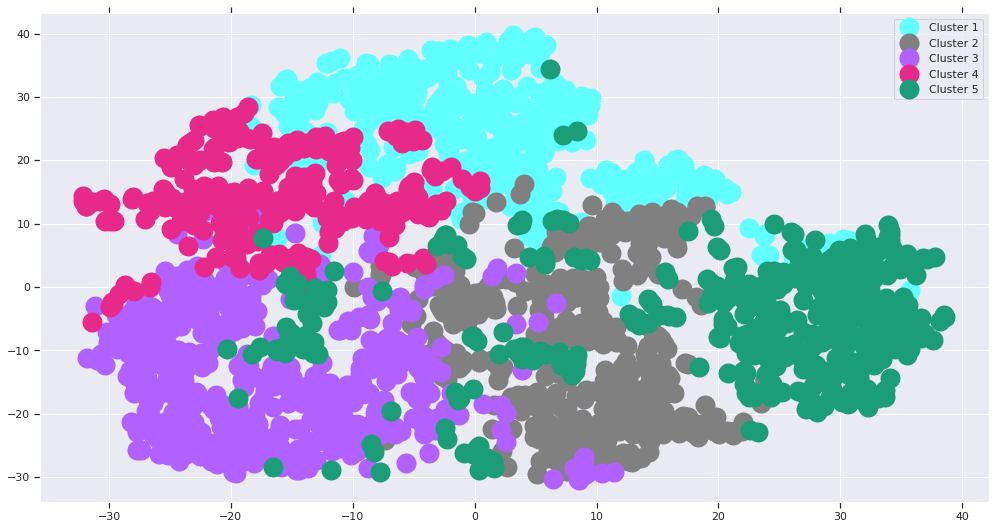

In [69]:
tsne = TSNE(n_components=2, init='random', random_state=42, perplexity=50)
pos = tsne.fit_transform(d2v_model.docvecs.vectors_docs[:2000]) 
xs, ys = pos[:, 0], pos[:, 1]

# Set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4',4:'Cluster 5'}
cluster_colors = {0: '#61ffff', 1: '#808080', 2: '#B061FF', 3: '#e7298a',4: '#1b9e77'}

# Plot clusters
df_plot = pd.DataFrame(dict(x=xs, y=ys, label=ac_docvec_clusters[0:2000])) 
groups = df_plot.groupby('label')
fig, ax = plt.subplots(figsize=(17, 9))

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, 
            label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
ax.legend(numpoints=1) 
plt.show()

### Comparision of 6 clustering method combinations

In [70]:
df.head(3)

,Title,Headline,Topic,CleanHeadline,HeadlineTokens,kmeans_tfidf,agglo_tfidf,kmeans_wordvec,agglo_wordvec,kmeans_docvec,agglo_docvec
13918,Chinas economy shows sign of recovery,These indicators show a moderate recovery in C...,economy,indicator show moderate recovery chinese econo...,"[indicator, show, moderate, recovery, chinese,...",3,2,4,4,1,0
26513,"Fed to hike rates three times in 2016, economi...",The world's largest economy is a bulwark for a...,economy,world largest economy bulwark increasingly sha...,"[world, largest, economy, bulwark, increasingl...",3,2,4,4,2,1
27900,Microsoft Office 2016 is now available on Appl...,Apple users can now get the same productivity ...,microsoft,apple user get productivity service applicatio...,"[apple, user, get, productivity, service, appl...",1,3,1,2,2,4


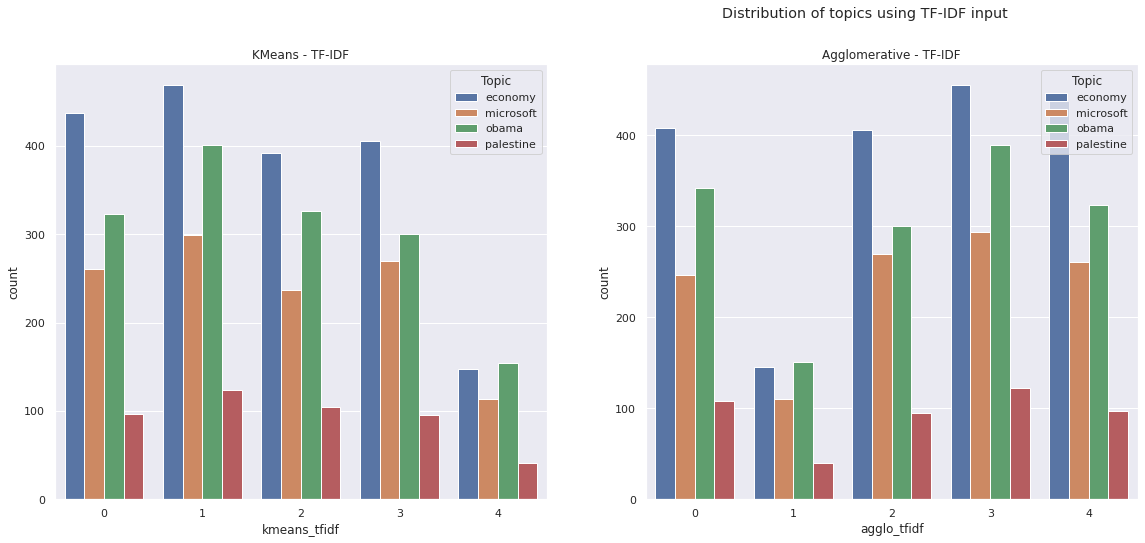

In [71]:
# Plot of distribution of topics in clusters
plt.figure(figsize=(30, 8))
plt.subplot(131)
sns.countplot(data=df,x='kmeans_tfidf',hue='Topic')
plt.title('KMeans - TF-IDF')

plt.subplot(132)
sns.countplot(data=df,x='agglo_tfidf',hue='Topic')
plt.title('Agglomerative - TF-IDF')
plt.suptitle('Distribution of topics using TF-IDF input')
plt.show()

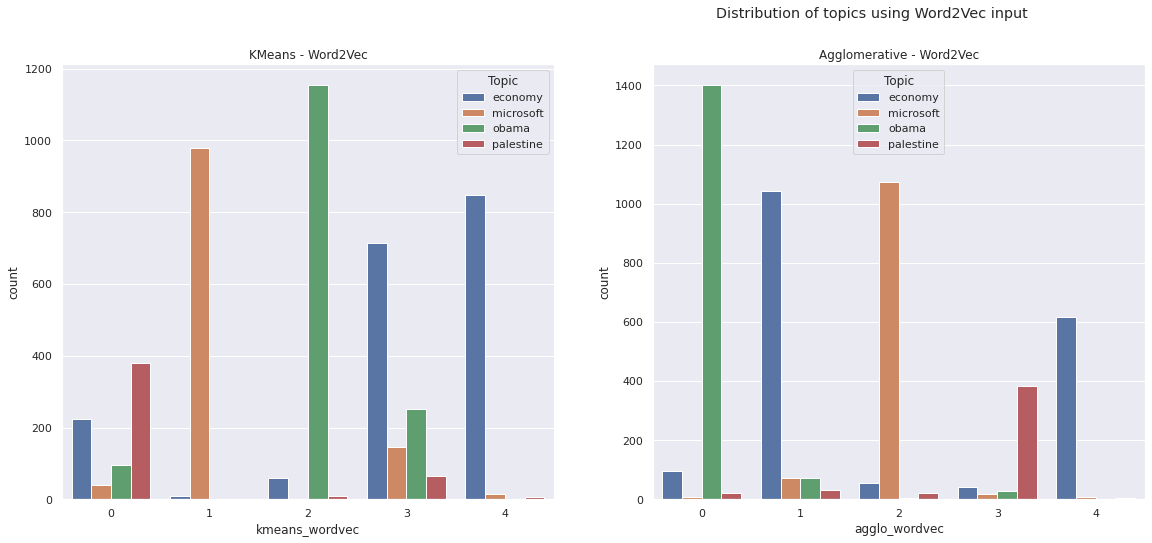

In [72]:
plt.figure(figsize=(30, 8))
plt.subplot(131)
sns.countplot(data=df,x='kmeans_wordvec',hue='Topic')
plt.title('KMeans - Word2Vec')

plt.subplot(132)
sns.countplot(data=df,x='agglo_wordvec',hue='Topic')
plt.title('Agglomerative - Word2Vec')
plt.suptitle('Distribution of topics using Word2Vec input')
plt.show()

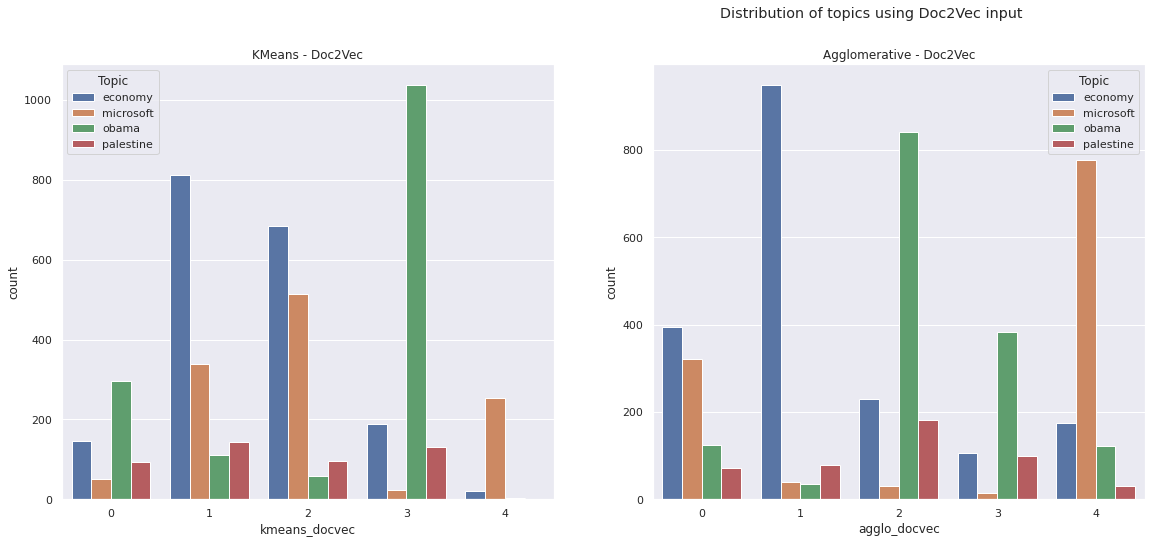

In [73]:
plt.figure(figsize=(30, 8))
plt.subplot(131)
sns.countplot(data=df,x='kmeans_docvec',hue='Topic')
plt.title('KMeans - Doc2Vec')

plt.subplot(132)
sns.countplot(data=df,x='agglo_docvec',hue='Topic')
plt.title('Agglomerative - Doc2Vec')

plt.suptitle('Distribution of topics using Doc2Vec input')
plt.show()


The six combination of algorithms and inputs gives varied results. 
Word2Vec input provides the best results. Especially with Agglomerative . The topics obama, microsoft, economy and palestine are isolated to a very great extent in clusters 0, 1, 2, 3 and 4. It outperforms K-Means as in the cluster 3 of KMeans model, there are mixed topics. 
Doc2Vec performs better than TF-IDF but its still not able to cluster topics as well as word2vec.
TF-IDF input with K-Means and Agglomerative clustering algorithms does not isolate topics in different clusters.
  
In conclusion, Agglomerative algorithm with word2vec input performs the best.

In [74]:
# Exporting to csv file
df = df.drop(columns=['CleanHeadline','HeadlineTokens'])
df.to_csv('A5-Clustering.csv')